In [1]:
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import time

### Data Collection

In [17]:
headers=[] #to store column names
data = [] #to store data
for i in range(2013,2023): #to get data from 2013-22
    URL='https://stats.espncricinfo.com/ci/engine/records/team/match_results.html?class=1;id={};type=year'.format(i) #url format for test match results pages
    page_content = requests.get(URL).text
    soup = BeautifulSoup(page_content)
    table = soup.find('table',attrs = {'class' : 'engineTable'}) #identifying the required table attribute
    #if headers is empty store the table headers in column list
    if(len(headers)==0): 
        heads = table.find_all('th') 
        for head in heads:
            headers.append(head.text)
    #extracting rows using table data from table body
    body = table.find('tbody')
    rows = body.find_all('tr')
    for row in rows:
        td = row.find_all('td')
        data_row = [k.text for k in td] #list of data text of each row
        data.append(data_row) #adding rows to data list


    

In [4]:
df = pd.DataFrame(data, columns = headers) #creating dataframe from extracted data
df.to_csv('test_cricket.csv', index=False) #creating csv file from dataframe

In [2]:
df1=pd.read_csv('test_cricket.csv') #reading data from csv file

In [4]:
df1.info() #information about the amount of data and datatypes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Team 1      419 non-null    object
 1   Team 2      419 non-null    object
 2   Winner      419 non-null    object
 3   Margin      350 non-null    object
 4   Ground      419 non-null    object
 5   Match Date  419 non-null    object
 6   Scorecard   419 non-null    object
dtypes: object(7)
memory usage: 23.0+ KB


### Data Cleaning

In [5]:
df1.drop_duplicates(inplace = True) #dropping duplicate rows 

In [6]:
#replacing margin of drawn matches with 'Doesn't Exist'
df1['Margin'].fillna('Doesn\'t Exist',inplace=True) 

In [7]:
df1.tail()

,Team 1,Team 2,Winner,Margin,Ground,Match Date,Scorecard
414,Australia,South Africa,Australia,6 wickets,Brisbane,"Dec 17-18, 2022",Test # 2482
415,Pakistan,England,England,8 wickets,Karachi,"Dec 17-20, 2022",Test # 2483
416,Bangladesh,India,India,3 wickets,Mirpur,"Dec 22-25, 2022",Test # 2484
417,Australia,South Africa,Australia,inns & 182 runs,Melbourne,"Dec 26-29, 2022",Test # 2485
418,Pakistan,New Zealand,drawn,Doesn't Exist,Karachi,"Dec 26-30, 2022",Test # 2486


In [8]:
# function to get start and end dates of test matches

def start_end(index,n):
    dates_temp = df1.loc[index]['Match Date'].split('-')
    dates_temp = [i.strip() for i in dates_temp]
    if(len(n)==4):
        dates_temp[0] += ', '+dates[0][index][3]
        dates_temp[1] = dates[0][index][0] + ' ' + dates_temp[1]
    elif(len(n)==5):
        dates_temp[0] += ', '+dates[0][index][4]
    return dates_temp[0],dates_temp[1]

# function to get year in which test match has ended
def match_year(n):
    if len(n)>3:
        return n[3]
    else:
        return n[2]

In [9]:
dates = df1['Match Date'].str.extractall('(\w+)') #seprately extracting the words in match date(e.g.:'Jan 2-4, 2013' -> [Jan,2,4,2013])
df1[['Start date','End date']]=[start_end(i,dates[0][i]) for i in df1.index] #adding start and end date columns
df1.head()

,Team 1,Team 2,Winner,Margin,Ground,Match Date,Scorecard,Start date,End date
0,South Africa,New Zealand,South Africa,inns & 27 runs,Cape Town,"Jan 2-4, 2013",Test # 2069,"Jan 2, 2013","Jan 4, 2013"
1,Australia,Sri Lanka,Australia,5 wickets,Sydney,"Jan 3-6, 2013",Test # 2070,"Jan 3, 2013","Jan 6, 2013"
2,South Africa,New Zealand,South Africa,inns & 193 runs,Gqeberha,"Jan 11-14, 2013",Test # 2071,"Jan 11, 2013","Jan 14, 2013"
3,South Africa,Pakistan,South Africa,211 runs,Johannesburg,"Feb 1-4, 2013",Test # 2072,"Feb 1, 2013","Feb 4, 2013"
4,South Africa,Pakistan,South Africa,4 wickets,Cape Town,"Feb 14-17, 2013",Test # 2073,"Feb 14, 2013","Feb 17, 2013"


In [10]:
#assigning the difference between end date and start date to 'Match Duration(in Days)' column
df1['Match Duration(in Days)'] = [int((pd.to_datetime(df1['End date'][i])-pd.to_datetime(df1['Start date'][i]))/np.timedelta64(1, 'D'))+1 for i in df1.index]

In [11]:
df1.loc[df1['Match Duration(in Days)']>5, 'Match Duration(in Days)'] = 5 #limiting match duration to 5 days(test matches only have 5 playing days)

In [12]:
df1['End Year'] = [list(dates[0][i])[-1] for i in df1.index] #adding 'End Year' column

In [13]:
df1['Match No.'] = [int(df1['Scorecard'].str.split('# ')[i][1]) for i in df1.index] #To get match numbers of test matches
df1.head()

,Team 1,Team 2,Winner,Margin,Ground,Match Date,Scorecard,Start date,End date,Match Duration(in Days),End Year,Match No.
0,South Africa,New Zealand,South Africa,inns & 27 runs,Cape Town,"Jan 2-4, 2013",Test # 2069,"Jan 2, 2013","Jan 4, 2013",3,2013,2069
1,Australia,Sri Lanka,Australia,5 wickets,Sydney,"Jan 3-6, 2013",Test # 2070,"Jan 3, 2013","Jan 6, 2013",4,2013,2070
2,South Africa,New Zealand,South Africa,inns & 193 runs,Gqeberha,"Jan 11-14, 2013",Test # 2071,"Jan 11, 2013","Jan 14, 2013",4,2013,2071
3,South Africa,Pakistan,South Africa,211 runs,Johannesburg,"Feb 1-4, 2013",Test # 2072,"Feb 1, 2013","Feb 4, 2013",4,2013,2072
4,South Africa,Pakistan,South Africa,4 wickets,Cape Town,"Feb 14-17, 2013",Test # 2073,"Feb 14, 2013","Feb 17, 2013",4,2013,2073


In [ ]:
#function to check whether a test match is drawn
def isdrawn(winner):
    if winner=='drawn':
        return 'Yes'
    else:
        return 'No'

df1['Match Drawn'] = df1['Winner'].apply(isdrawn) #Adding 'Match Drawn column to easily identify drawn matches '

### Data Analysis and visualization

[Text(0, 0, '43'),
 Text(0, 0, '42'),
 Text(0, 0, '43'),
 Text(0, 0, '47'),
 Text(0, 0, '47'),
 Text(0, 0, '48'),
 Text(0, 0, '39'),
 Text(0, 0, '22'),
 Text(0, 0, '44'),
 Text(0, 0, '43')]

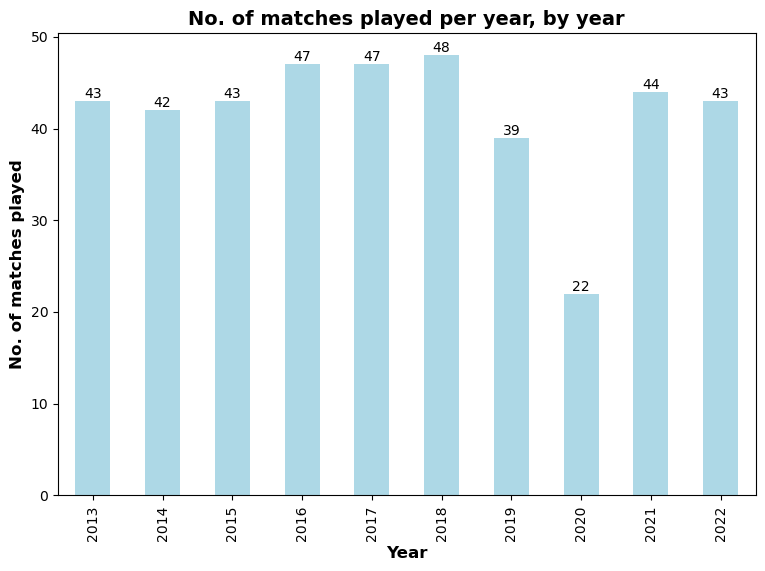

In [14]:
#plotting the number of matches played per year, yearwise
plt.figure(figsize=(9,6),dpi=100)
plt.title('No. of matches played per year, by year', fontsize = 14, fontweight = 'bold')
ax = df1['End Year'].value_counts()[df1['End Year'].unique()].plot(kind='bar', color = 'lightblue')
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('No. of matches played', fontsize = 12, fontweight = 'bold')
ax.bar_label(ax.containers[0])

## inferences - 
### The number of matches played in 2019 decreased considerably when compared to previous years
### The number of matches played in 2020 decreased drastically due to uncontrollable reasons(Covid-19) 

In [17]:
df1.head(1)

,Team 1,Team 2,Winner,Margin,Ground,Match Date,Scorecard,Start date,End date,Match Duration(in Days),End Year,Match No.,Match Drawn
0,South Africa,New Zealand,South Africa,inns & 27 runs,Cape Town,"Jan 2-4, 2013",Test # 2069,"Jan 2, 2013","Jan 4, 2013",3,2013,2069,No


In [114]:
# df2=df1.groupby(['End Year']).agg({'Match Drawn':'value_counts'})
# ax = df2.groupby(level=0).apply(lambda x : 100 * x / x.sum()).plot(kind = 'bar', figsize=(9,6))
# ax.bar_label(ax.containers[0], fmt = '%.1f')

Text(0, 0.5, 'Percentage of Matches not Drawn/Drawn')

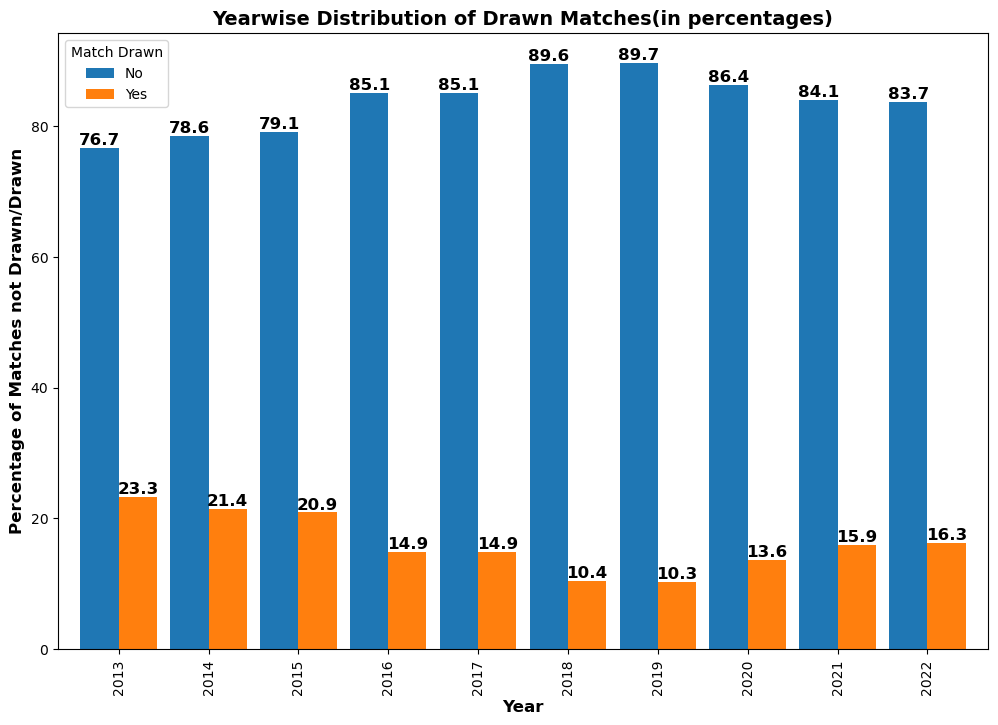

In [42]:
#grouping the data by yearwise plotting the distribution of percentages of drawn match and matches not drawn by year
ax = pd.crosstab(df1['End Year'], columns = df1['Match Drawn']).apply(lambda x : 100 * x / x.sum(), axis = 1).plot.bar(figsize = (12,8), width = 0.85)
for c in ax.containers:
    ax.bar_label(c, fmt = '%.1f', fontweight = 'bold', fontsize = 12)
ax.set_title('Yearwise Distribution of Drawn Matches(in percentages)', fontweight = 'bold', fontsize = 14)
ax.set_xlabel('Year', fontsize = 12, fontweight = 'bold')
ax.set_ylabel('Percentage of Matches not Drawn/Drawn', fontsize = 12, fontweight = 'bold')

## inferences - 
### The percentage of drawn matches kept on decreasing during 2013-2019 and has risen during 2020-2022
### This could be a result of teams which have started adopting aggressive approach because of the impact of the limited overs cricket

In [63]:
#creating dataframe with the teamwise match result data with end year of the matches
t12=df1[['Team 1','Team 2']] 
d12=pd.concat([df1[['Match Drawn','End Year']],df1[['Match Drawn','End Year']]], ignore_index = True)
t= pd.concat([t12.loc[:, col] for col in t12.columns], ignore_index=True) #list of all the teams
td = pd.concat([t,d12],axis = 1)

Text(0, 0.5, 'Percentage of Matches not Drawn/Drawn by Team')

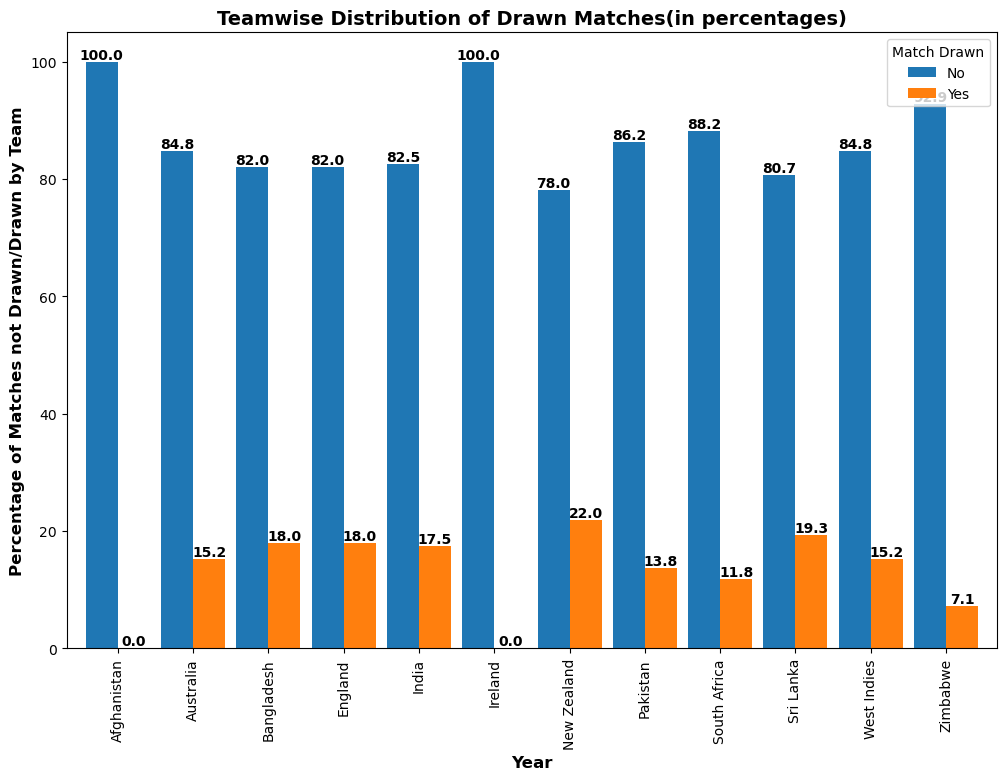

In [40]:
#grouping the data teamwise and plotting the Distribution of Drawn Matches by Teams(in percentages)
ax = pd.crosstab(td.iloc[:,0] , columns = td['Match Drawn']).apply(lambda x : 100 * x / x.sum(), axis = 1).plot.bar(figsize = (12,8), width = 0.85)
for c in ax.containers:
    ax.bar_label(c, fmt = '%.1f', fontweight = 'bold', fontsize = 10)
ax.set_title('Teamwise Distribution of Drawn Matches(in percentages)', fontweight = 'bold', fontsize = 14)
ax.set_xlabel('Year', fontsize = 12, fontweight = 'bold')
ax.set_ylabel('Percentage of Matches not Drawn/Drawn by Team', fontsize = 12, fontweight = 'bold')

Text(0, 0.5, 'No. of Matches')

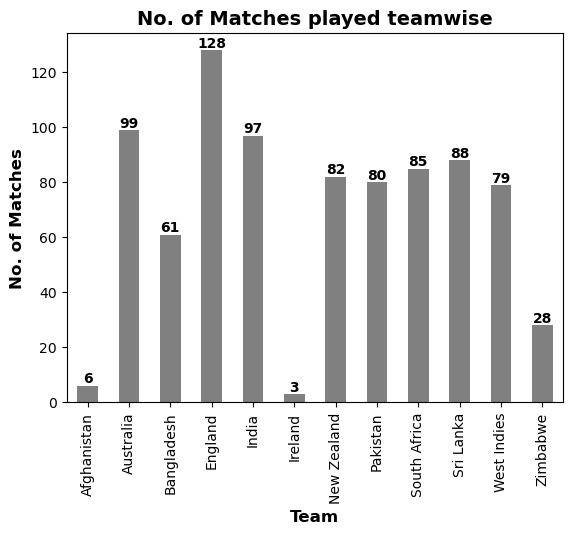

In [38]:
#grouping the data teamwise and plotting the Distribution of Drawn Matches by Teams(in percentages)
ax=pd.crosstab(td.iloc[:,0] , columns = td['End Year']).sum(axis = 1).plot.bar(color = 'grey')
for c in ax.containers:
    ax.bar_label(c, fontweight = 'bold', fontsize = 10)
ax.set_title('No. of Matches played teamwise', fontweight = 'bold', fontsize = 14)
ax.set_xlabel('Team', fontsize = 12, fontweight = 'bold')
ax.set_ylabel('No. of Matches', fontsize = 12, fontweight = 'bold')

## inferences -
### if we consider the number of matches played by each team and the percentage of drawn matches teamwise, SouthAfrica has played with most aggressive intent for getting the results in as many matches as possible, which is evident from its draw match percentages, followed by Pakistan, Australia, West Indies and India

In [44]:
d1=pd.crosstab([td.iloc[:,0],td['End Year']], td['Match Drawn']) #grouping data teamwise and yearwise

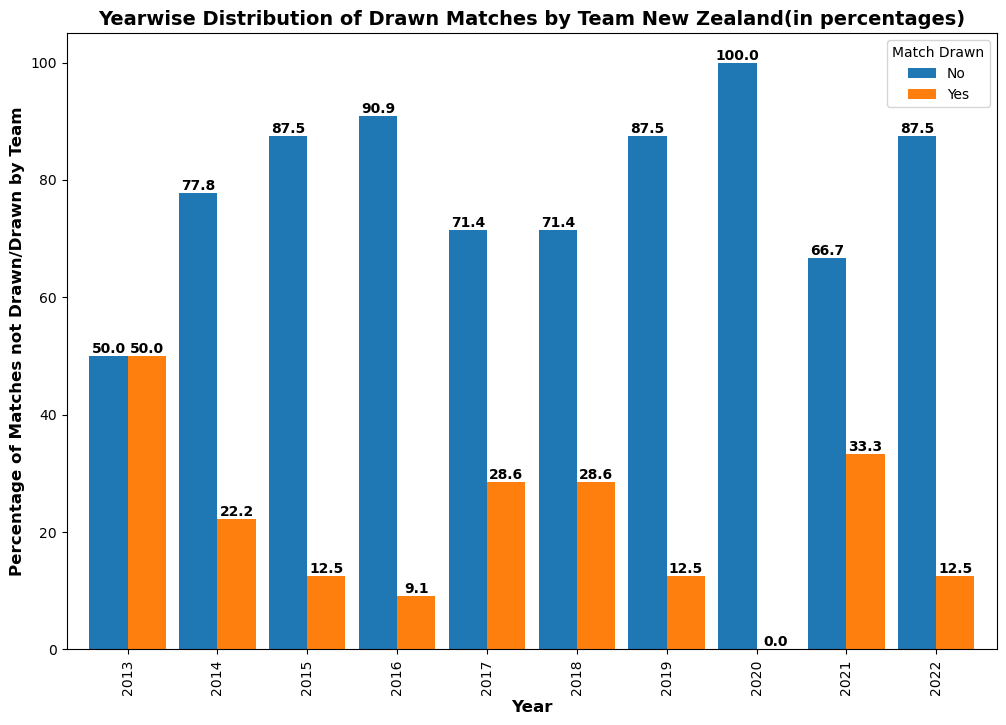

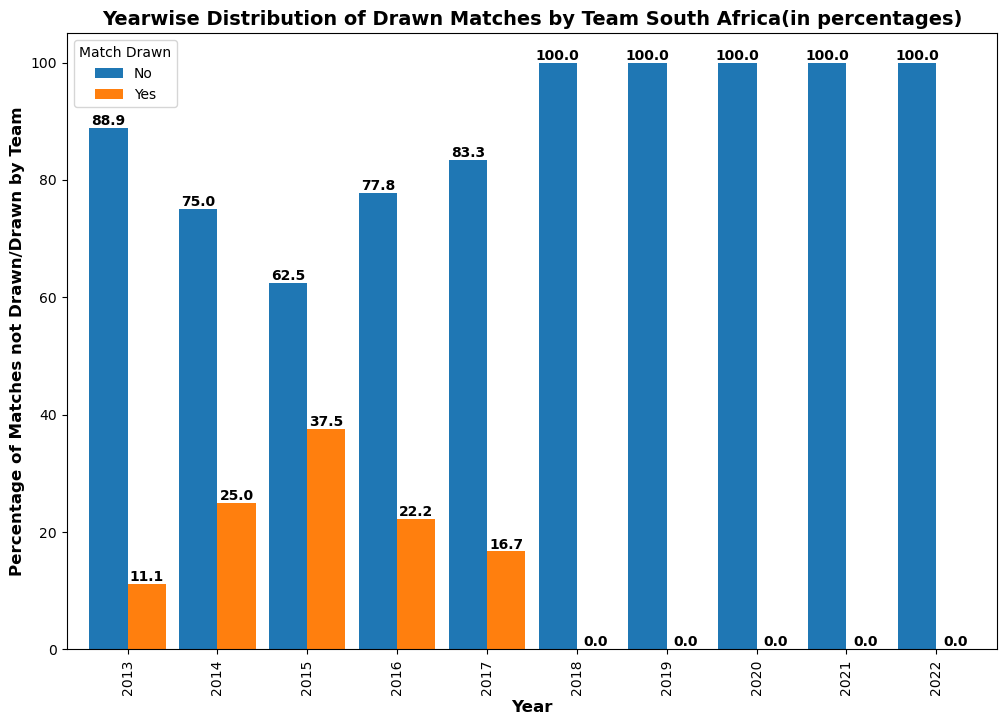

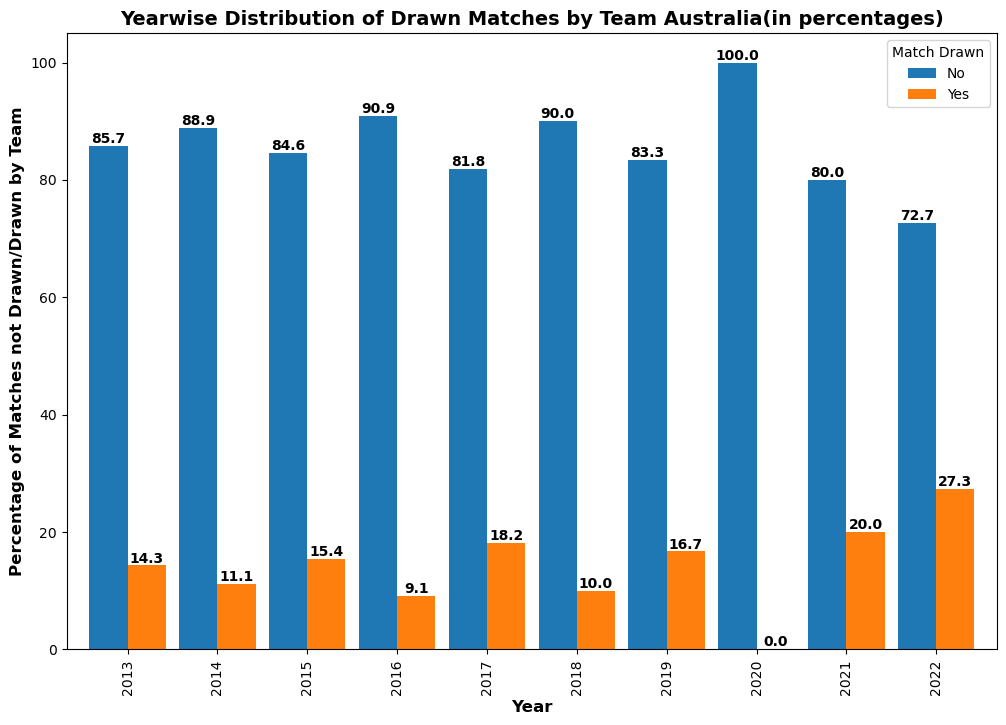

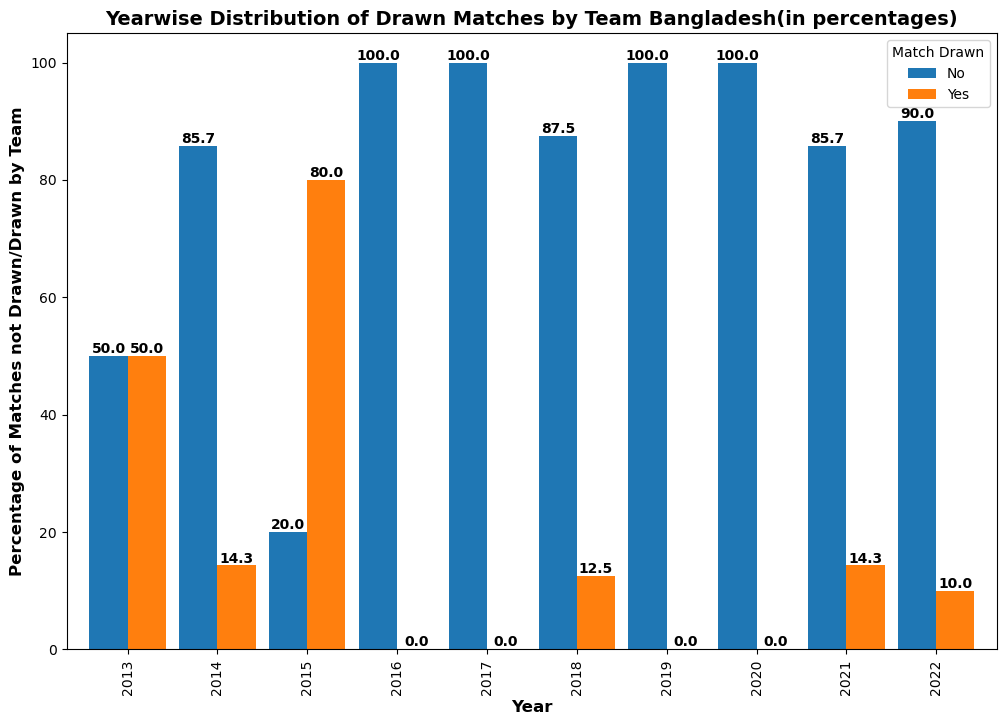

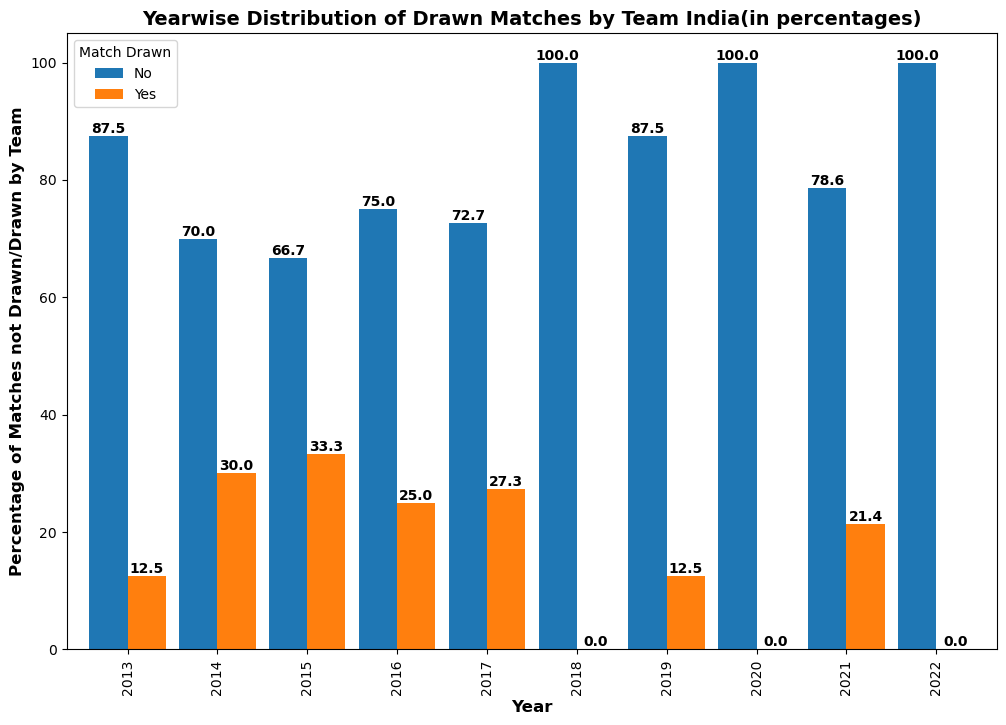

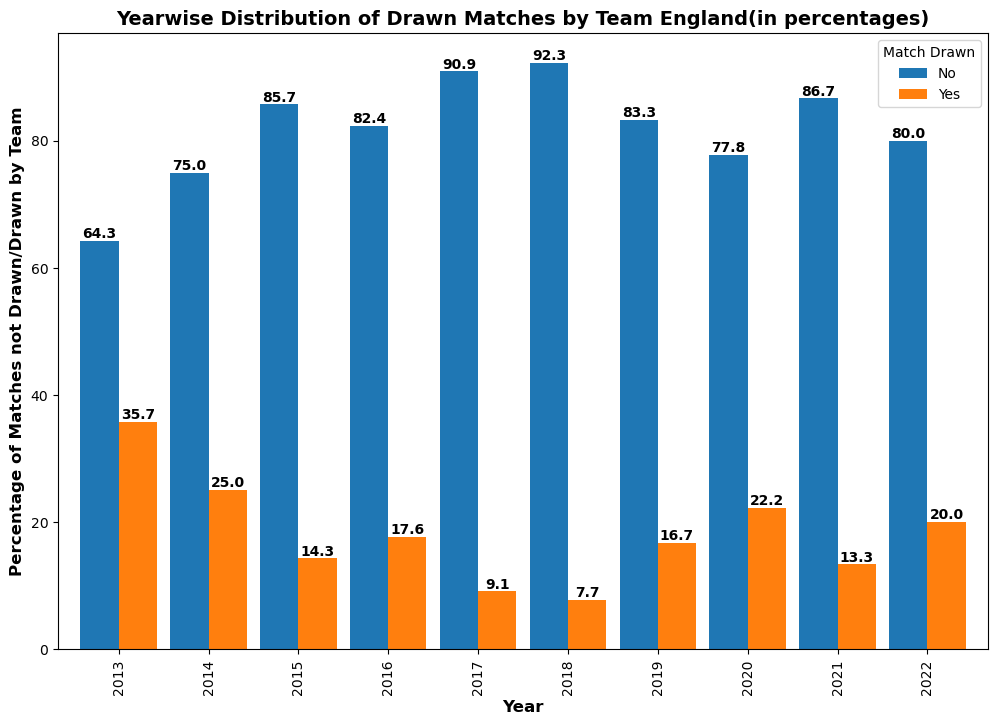

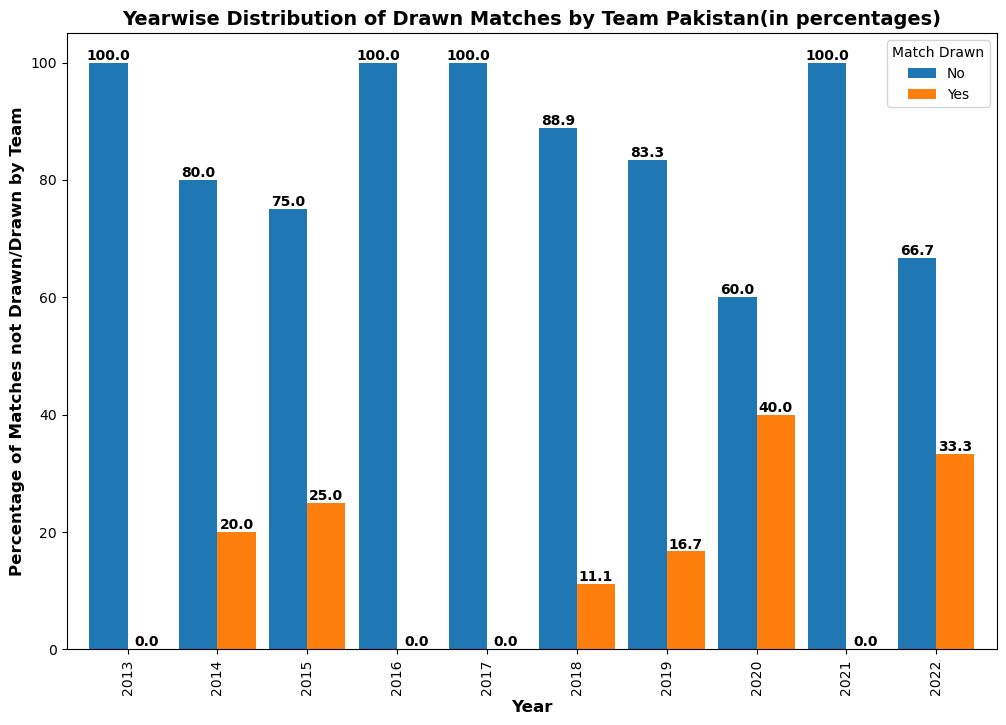

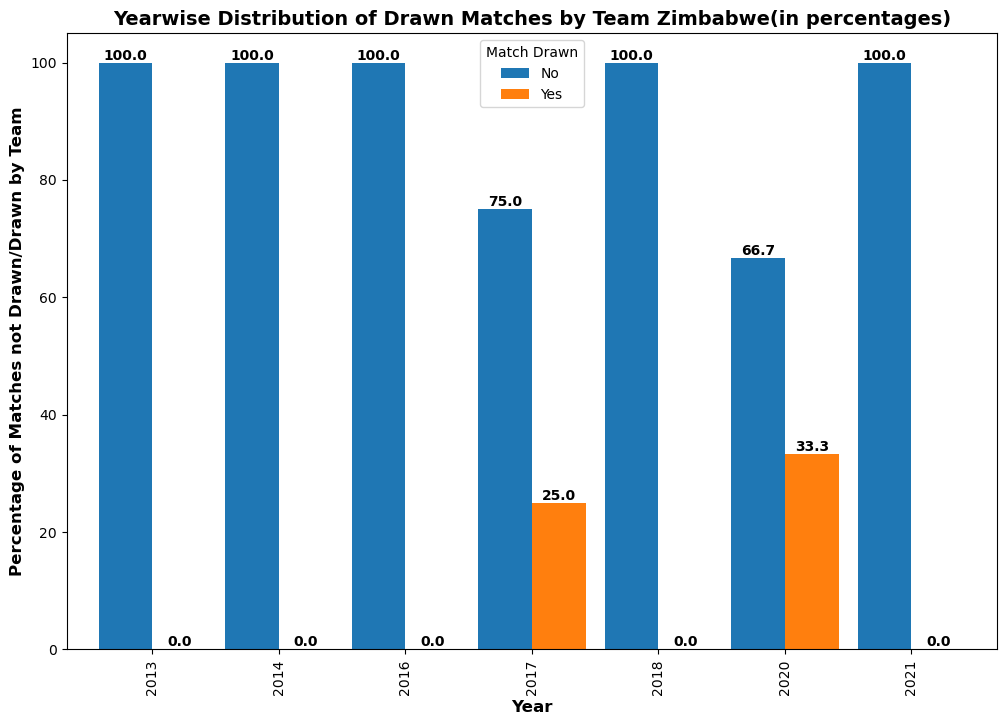

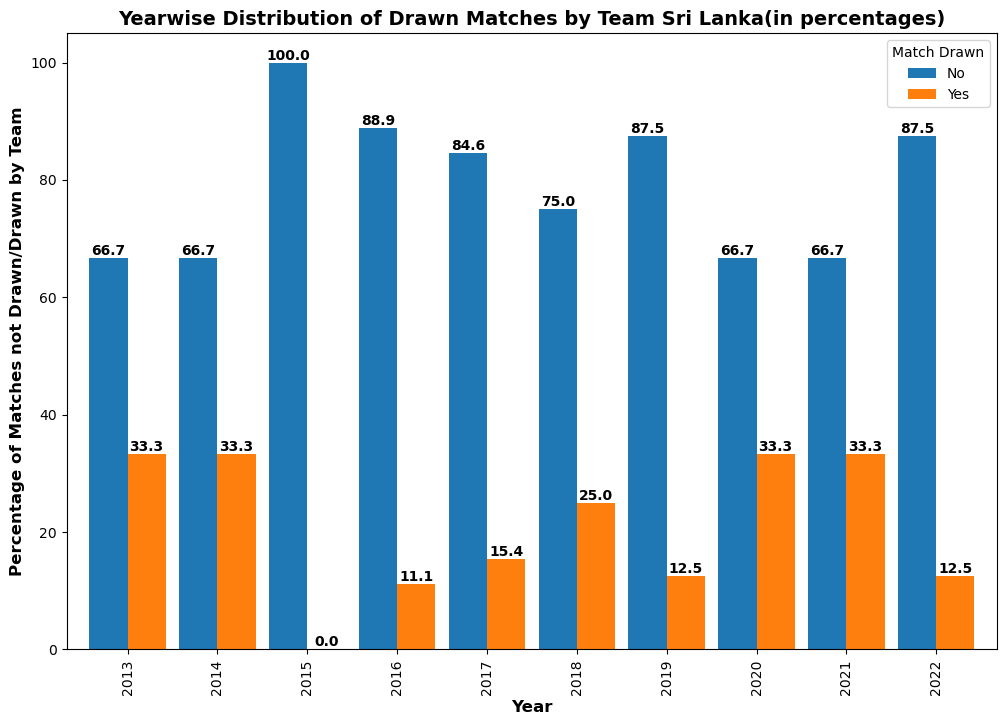

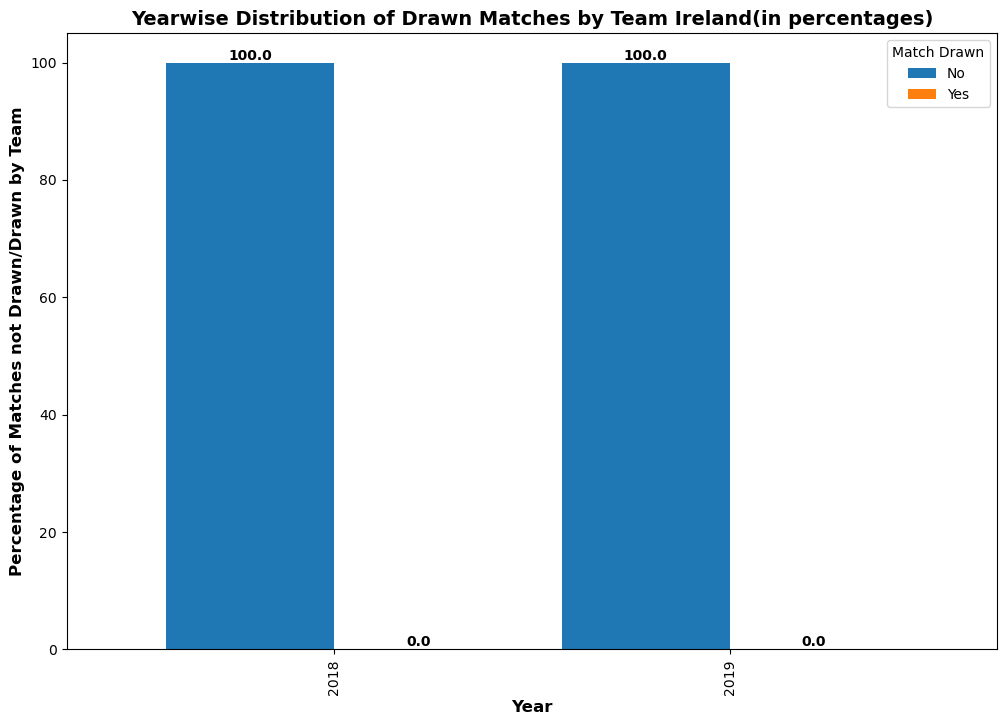

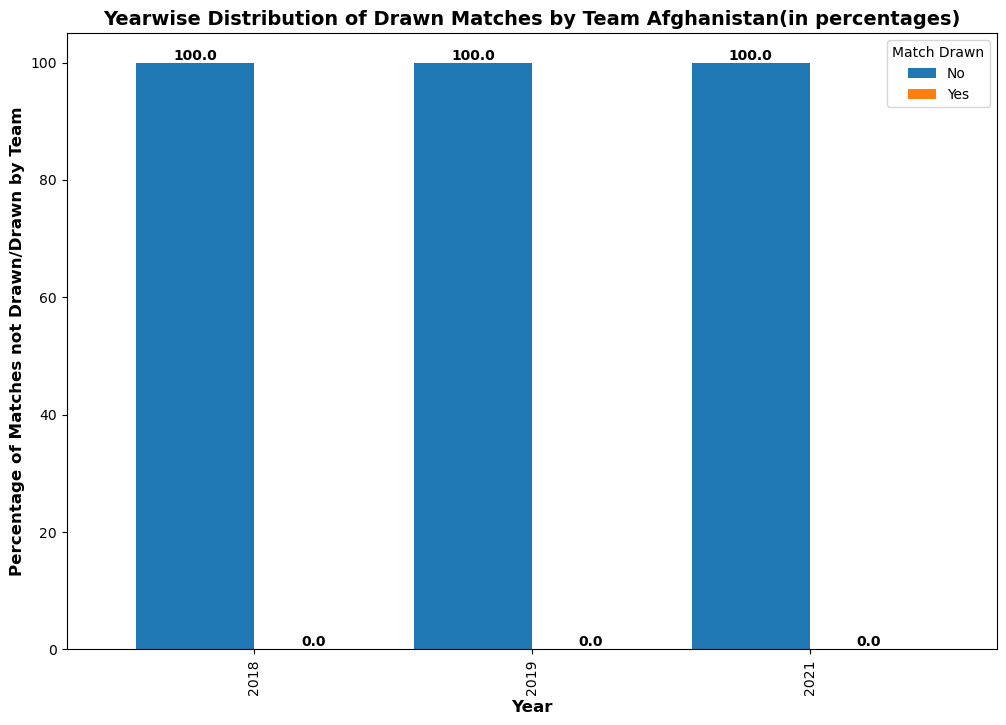

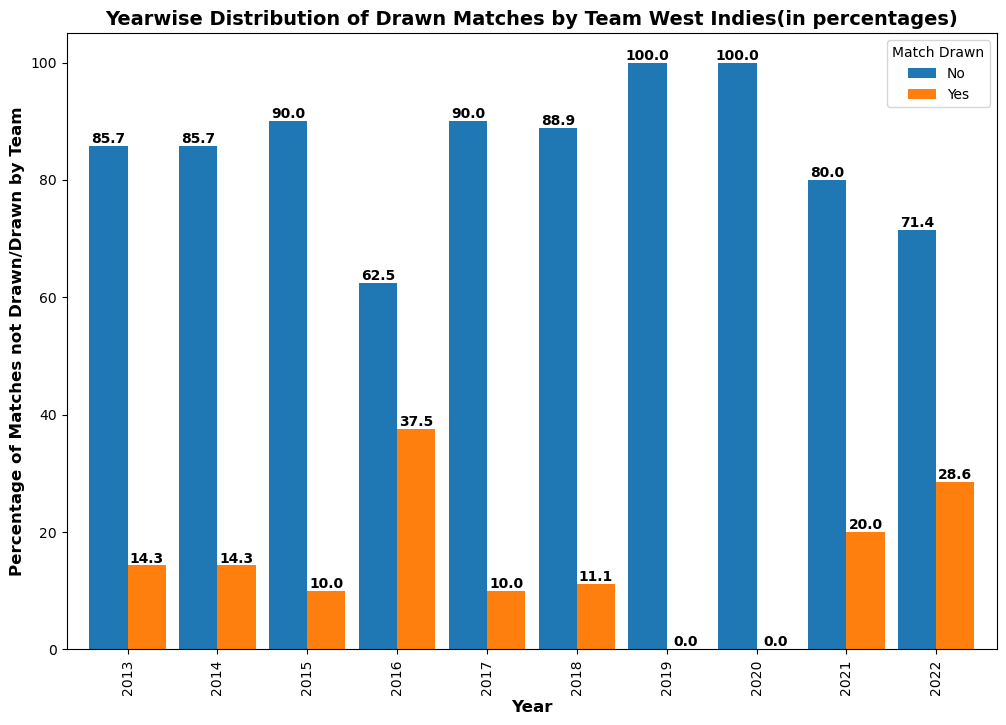

In [45]:
#plotting Yearwise Distribution of Drawn Matches by Team
for i in set(t):
    ax = d1.loc[i].apply(lambda x : 100 * x / x.sum(), axis =1).fillna('0').plot.bar(figsize = (12,8), width = 0.85)
    for c in ax.containers:
        ax.bar_label(c, fmt = '%.1f', fontweight = 'bold', fontsize = 10)
    ax.set_title(f'Yearwise Distribution of Drawn Matches by Team {i}(in percentages)', fontweight = 'bold', fontsize = 14)
    ax.set_xlabel('Year', fontsize = 12, fontweight = 'bold')
    ax.set_ylabel('Percentage of Matches not Drawn/Drawn by Team', fontsize = 12, fontweight = 'bold')

In [133]:
# d2=td.groupby([td.iloc[:,0]]).agg({'End Year':'value_counts'}).sort_index() #grouping data teamwise and yearwise
# # plotting Yearwise Distribution of Matches played by Team
# for i in set(t):
#     ax = d2.loc[i].fillna('0').plot.bar(figsize = (12,8), width = 0.85)
#     for c in ax.containers:
#         ax.bar_label(c, fmt = '%.1f', fontweight = 'bold', fontsize = 10)
#     ax.set_title(f'Yearwise Distribution of Matches played by Team {i}(in percentages)', fontweight = 'bold', fontsize = 14)
#     ax.set_xlabel('Year', fontsize = 12, fontweight = 'bold')
#     ax.set_ylabel('Percentage of Matches not Drawn/Drawn by Team', fontsize = 12, fontweight = 'bold')

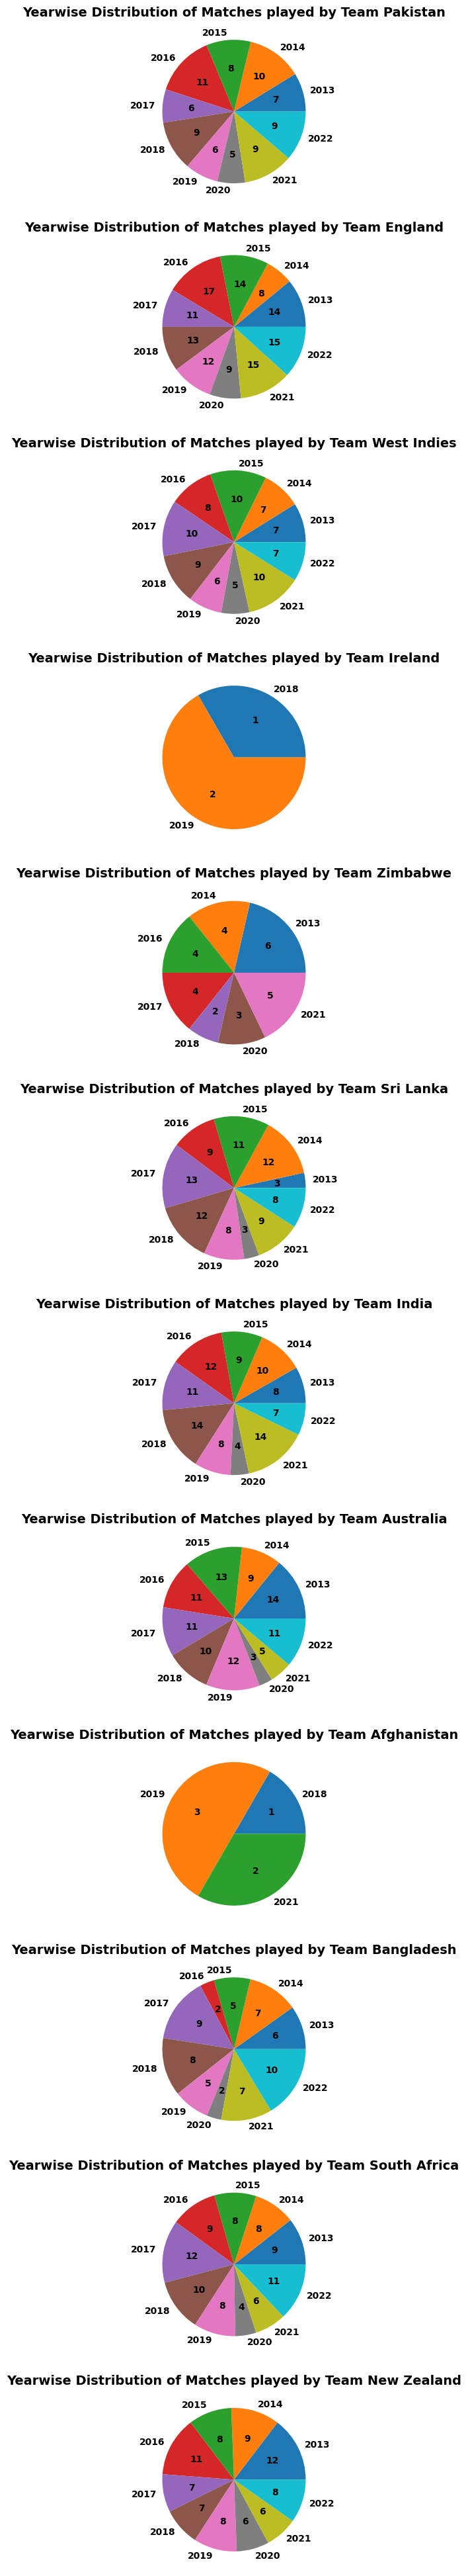

In [132]:
def func(pct,allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{absolute:d}"

d2=td.groupby([td.iloc[:,0]]).agg({'End Year':'value_counts'}).sort_index() #grouping data teamwise and yearwise
# plotting Yearwise Distribution of Matches played by Team
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(50,50))
c=0
for i in set(t):
    py = d2.loc[i].fillna('0')
    lbl = [py.iloc[j,:].name for j in range(len(py))]
    ax1 = plt.subplot2grid((12,1),(c,0))
    plt.pie(py.iloc[:,0], autopct=lambda pct: func(pct, py.iloc[:,0]), labels = lbl, textprops={'fontweight':'bold'} )
    c+=1
    plt.title(f'Yearwise Distribution of Matches played by Team {i}', fontweight = 'bold', fontsize = 14)

## inferences -
### Draw matches percentage has decreased from 23.3 in 2013 to 10.3 in 2019 and has increased steadily to 16.7 in 2022. 
### England cricket team has played most number of matches(128) from  2013-2022 and have a draw match percentage of 18. 
### Among teams which have played over 50 matches in this span, South Africa has least draw match percentage(11.8) followed by Pakistan(13.8), Australia(15.2) and West Indies(15.2).
### The above data indicates that South Africa has played most aggressive brand of cricket to get results in as many matches as possible and many teams have started adopting similar strategies. 
